In [3]:
import torch
import os
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

### Download the data for training and validation

In [4]:
data_root = 'data'
if not os.path.exists(os.path.join(data_root, 'FashionMNIST')):
    download = True
    
else:
    download = False
    
training_data = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = download,
    transform = ToTensor()
)

In [5]:
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=download,
    transform=ToTensor()
)

### Iterating and Visulaising the Dataset

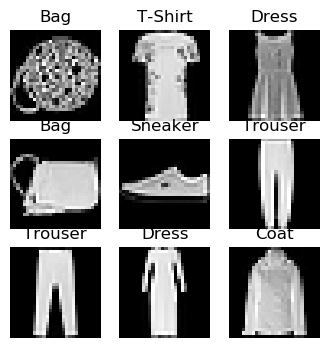

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(4,4)) # size of plotted images
cols, rows = 3,3 # layout of plotted images

# loop over 10 (not inclusive) images in the dataset 
for i in range(1, cols*rows +1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item() # return random integer 
    img, label = training_data[sample_idx] # get image at random index
    figure.add_subplot(rows,cols,i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(),cmap='gray')
plt.show()
        

### Create a Custom Dataset for your files

A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. Take a look at this implementation; the FashionMNIST images are stored in a directory img_dir, and their labels are stored separately in a CSV file annotations_file.

In [7]:
import os
import pandas as pd
from torchvision.io import read_image

In [8]:
class CustomImageDataset(Dataset):
    
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

### Preparing your data for training with DataLoaders
The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Iterate through the DataLoader
We have loaded that dataset into the DataLoader and can iterate through the dataset as needed. Each iteration below returns a batch of train_features and train_labels (containing batch_size=64 features and labels respectively). Because we specified shuffle=True, after we iterate over all batches the data is shuffled (for finer-grained control over the data loading order, take a look at Samplers).

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


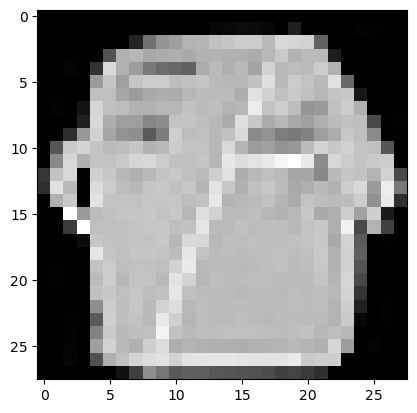

label: 8


In [10]:
# display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f'label: {label}')

### TRANSFORMS
Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training.

All TorchVision datasets have two parameters -transform to modify the features and target_transform to modify the labels - that accept callables containing the transformation logic. The torchvision.transforms module offers several commonly-used transforms out of the box.

The FashionMNIST features are in PIL Image format, and the labels are integers. For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. To make these transformations, we use ToTensor and Lambda.

In [11]:
from torchvision.transforms import Lambda

ds = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

# the lambda function applies to each recored when it is loaded by the dataloader,
# so whatever the "y" value of that record, it will be one-hot encoded

### ToTensor()
ToTensor converts a PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range [0., 1.]

### Lambda Transforms
Lambda transforms apply any user-defined lambda function. Here, we define a function to turn the integer into a one-hot encoded tensor. It first creates a zero tensor of size 10 (the number of labels in our dataset) and calls scatter_ which assigns a value=1 on the index as given by the label y.

### BUILD THE NEURAL NETWORK
Neural networks comprise of layers/modules that perform operations on data. The torch.nn namespace provides all the building blocks you need to build your own neural network. Every module in PyTorch subclasses the nn.Module. A neural network is a module itself that consists of other modules (layers). This nested structure allows for building and managing complex architectures easily.

In the following sections, we’ll build a neural network to classify images in the FashionMNIST dataset.

In [12]:
from torch import nn
from torchvision import datasets, transforms

### Get Device for Training
We want to be able to train our model on a hardware accelerator like the GPU or MPS, if available. Let’s check to see if torch.cuda or torch.backends.mps are available, otherwise we use the CPU.

In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


### Define the Class
We define our neural network by subclassing nn.Module, and initialize the neural network layers in __init__. Every nn.Module subclass implements the operations on input data in the forward method.

In [14]:
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
        
    def forward(self, x): # called by pytorch when data is passed to the model
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We create an instance of NeuralNetwork, and move it to the device, and print its structure.



In [15]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This executes the model’s forward, along with some background operations. Do not call model.forward() directly!

Calling the model on the input returns a 2-dimensional tensor with dim=0 corresponding to each output of 10 raw predicted values for each class, and dim=1 corresponding to the individual values of each output. We get the prediction probabilities by passing it through an instance of the nn.Softmax module.

In [16]:
X = torch.rand(1,28,28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([2])


In [17]:
pred_probab

tensor([[0.1052, 0.0898, 0.1246, 0.0780, 0.0915, 0.1111, 0.0973, 0.0986, 0.1055,
         0.0984]], grad_fn=<SoftmaxBackward0>)

### Model Layers
Let’s break down the layers in the FashionMNIST model. To illustrate it, we will take a sample minibatch of 3 images of size 28x28 and see what happens to it as we pass it through the network.

In [18]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


### nn.Flatten
We initialize the nn.Flatten layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values (the minibatch dimension (at dim=0) is maintained).

In [19]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


### nn.Linear
The linear layer is a module that applies a linear transformation on the input using its stored weights and biases.

A function is said to be linear if a change in output is directly proportional to a change in input

In [21]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


### nn.ReLU
Non-linear activations are what create the complex mappings between the model’s inputs and outputs. They are applied after linear transformations to introduce nonlinearity, helping neural networks learn a wide variety of phenomena.

In this model, we use nn.ReLU between our linear layers, but there’s other activations to introduce non-linearity in your model.

In [22]:
print(f"Before reLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before reLU: tensor([[-0.0552, -0.4107,  0.2140,  0.0109, -0.0733, -0.1092, -0.2836,  0.3646,
         -0.0767,  0.4655, -0.1902, -0.3910,  0.0173, -0.4797, -0.4070,  0.2874,
         -0.2911, -0.1182,  0.2450, -0.4242],
        [-0.4380, -0.4504,  0.0968,  0.0074, -0.5694, -0.2902, -0.3954,  0.3964,
         -0.3040,  0.2412, -0.4759, -0.3222, -0.0955, -0.2946, -0.6493, -0.1640,
         -0.0141,  0.1837,  0.2145, -0.7735],
        [-0.3746, -0.4572,  0.1634,  0.0162, -0.4976,  0.0198, -0.1684,  0.4491,
         -0.3842, -0.1413, -0.1973, -0.1438,  0.2471, -0.4971, -1.0397,  0.2032,
         -0.1372,  0.0102,  0.1261, -0.9208]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.0000, 0.2140, 0.0109, 0.0000, 0.0000, 0.0000, 0.3646, 0.0000,
         0.4655, 0.0000, 0.0000, 0.0173, 0.0000, 0.0000, 0.2874, 0.0000, 0.0000,
         0.2450, 0.0000],
        [0.0000, 0.0000, 0.0968, 0.0074, 0.0000, 0.0000, 0.0000, 0.3964, 0.0000,
         0.2412, 0.0000, 0.0000, 0.0000, 0.0000, 0.00

### nn.Sequential
nn.Sequential is an ordered container of modules. The data is passed through all the modules in the same order as defined. You can use sequential containers to put together a quick network like seq_modules.

In [23]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20,10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

In [24]:
logits

tensor([[ 0.1949, -0.0398,  0.0061, -0.0239, -0.0838, -0.0615,  0.1711,  0.0603,
         -0.0592,  0.0671],
        [ 0.1728, -0.0749, -0.0009, -0.0772, -0.1348, -0.1691,  0.0718, -0.0232,
         -0.0492,  0.0043],
        [ 0.1839, -0.0429, -0.0486, -0.0479, -0.1101, -0.0542,  0.1609,  0.0718,
         -0.0355,  0.0980]], grad_fn=<AddmmBackward0>)

In [25]:
input_image

tensor([[[0.5733, 0.7434, 0.9177,  ..., 0.7747, 0.0284, 0.3268],
         [0.3027, 0.6468, 0.1585,  ..., 0.5086, 0.7153, 0.8362],
         [0.2331, 0.9825, 0.0924,  ..., 0.0712, 0.5146, 0.3235],
         ...,
         [0.3062, 0.3630, 0.9762,  ..., 0.2561, 0.2867, 0.7452],
         [0.0089, 0.6584, 0.2330,  ..., 0.1876, 0.5530, 0.8141],
         [0.3043, 0.9762, 0.7303,  ..., 0.8475, 0.1042, 0.7563]],

        [[0.1391, 0.8644, 0.3619,  ..., 0.6090, 0.7249, 0.5417],
         [0.6507, 0.5749, 0.3712,  ..., 0.6028, 0.2898, 0.3501],
         [0.8259, 0.9157, 0.1385,  ..., 0.7715, 0.8411, 0.6894],
         ...,
         [0.0605, 0.8650, 0.6292,  ..., 0.2026, 0.1099, 0.2239],
         [0.3200, 0.7883, 0.4490,  ..., 0.2628, 0.0081, 0.8603],
         [0.8583, 0.1734, 0.0820,  ..., 0.0024, 0.6361, 0.2782]],

        [[0.2907, 0.3756, 0.2893,  ..., 0.1302, 0.2043, 0.4752],
         [0.7293, 0.4342, 0.4472,  ..., 0.3768, 0.5883, 0.9843],
         [0.1076, 0.3919, 0.6375,  ..., 0.2451, 0.1695, 0.

### nn.Softmax
The last linear layer of the neural network returns logits - raw values in [-infty, infty] - which are passed to the nn.Softmax module. The logits are scaled to values [0, 1] representing the model’s predicted probabilities for each class. dim parameter indicates the dimension along which the values must sum to 1.

In [26]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

### Model Parameters
Many layers inside a neural network are parameterized, i.e. have associated weights and biases that are optimized during training. Subclassing nn.Module automatically tracks all fields defined inside your model object, and makes all parameters accessible using your model’s parameters() or named_parameters() methods.

In this example, we iterate over each parameter, and print its size and a preview of its values.

In [28]:
print(f"Model Structure: {model}\n\n")
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values: {param[:2]}")

Model Structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values: tensor([[ 0.0120, -0.0175, -0.0334,  ...,  0.0084, -0.0316, -0.0210],
        [ 0.0174, -0.0193,  0.0037,  ..., -0.0242,  0.0315,  0.0249]],
       grad_fn=<SliceBackward0>)
Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values: tensor([-0.0276,  0.0030], grad_fn=<SliceBackward0>)
Layer: linear_relu_stack.2.weight | Size: torch.Size([10, 512]) | Values: tensor([[ 0.0275, -0.0100, -0.0085,  ..., -0.0047, -0.0422, -0.0344],
        [ 0.0073,  0.0127, -0.0186,  ..., -0.0383, -0.0369,  0.0277]],
       grad_fn=<SliceBackward0>)
Layer: linear_relu_stack.2.bias | Size: torch.Size([10]) | Values: tensor([0.0344, 0.0150], grad_fn=<SliceBackward0>)


### AUTOMATIC DIFFERENTIATION WITH TORCH.AUTOGRAD
When training neural networks, the most frequently used algorithm is back propagation. In this algorithm, parameters (model weights) are adjusted according to the gradient of the loss function with respect to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine called torch.autograd. It supports automatic computation of gradient for any computational graph.

Consider the simplest one-layer neural network, with input x, parameters w and b, and some loss function. It can be defined in PyTorch in the following manner:

In [29]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

# the loss function also applies a sigmoid function to z to convert the raw value logit to a probability

### Tensors, Functions and Computational graph
This code defines the following computational graph:

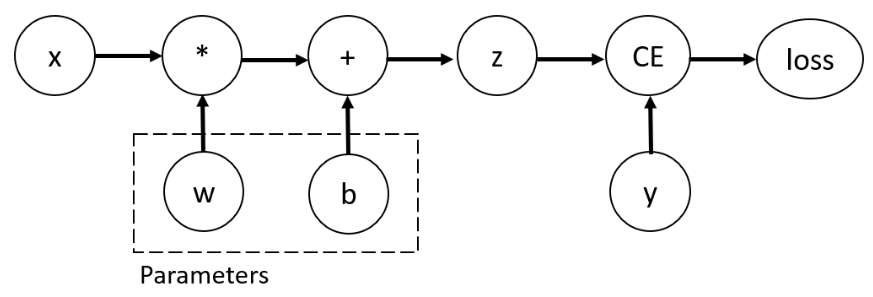

In this network, w and b are parameters, which we need to optimize. Thus, we need to be able to compute the gradients of loss function with respect to those variables. In order to do that, we set the requires_grad property of those tensors.

NOTE

You can set the value of requires_grad when creating a tensor, or later by using x.requires_grad_(True) method.

A function that we apply to tensors to construct computational graph is in fact an object of class Function. This object knows how to compute the function in the forward direction, and also how to compute its derivative during the backward propagation step. A reference to the backward propagation function is stored in grad_fn property of a tensor. You can find more information of Function in the documentation.

In [32]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x0000011D093B8C88>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x0000011D093B8B88>


### Computing Gradients
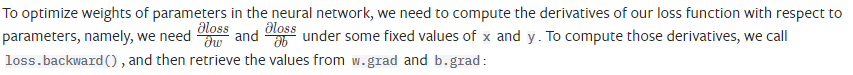

In [33]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2345, 0.1338, 0.0852],
        [0.2345, 0.1338, 0.0852],
        [0.2345, 0.1338, 0.0852],
        [0.2345, 0.1338, 0.0852],
        [0.2345, 0.1338, 0.0852]])
tensor([0.2345, 0.1338, 0.0852])


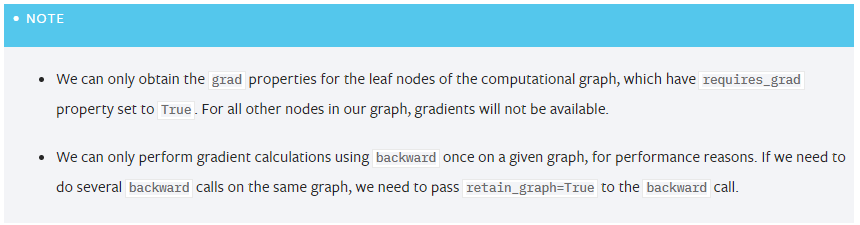

### Disabling Gradient Tracking
By default, all tensors with requires_grad=True are tracking their computational history and support gradient computation. However, there are some cases when we do not need to do that, for example, when we have trained the model and just want to apply it to some input data, i.e. we only want to do forward computations through the network. We can stop tracking computations by surrounding our computation code with torch.no_grad() block:

In [34]:
z = torch.matmul(x,w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x,w)+b

print(z.requires_grad)

True
False


Another way to achieve the same result is to use the detach() method on the tensor:

In [35]:
z = torch.matmul(x,w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


There are reasons you might want to disable gradient tracking:
To mark some parameters in your neural network as frozen parameters.

To speed up computations when you are only doing forward pass, because computations on tensors that do not track gradients would be more efficient.

### More on Computational Graphs
Conceptually, autograd keeps a record of data (tensors) and all executed operations (along with the resulting new tensors) in a directed acyclic graph (DAG) consisting of Function objects. In this DAG, leaves are the input tensors, roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule.

In a forward pass, autograd does two things simultaneously:

- run the requested operation to compute a resulting tensor

- maintain the operation’s gradient function in the DAG.

The backward pass kicks off when .backward() is called on the DAG root. autograd then:

- computes the gradients from each .grad_fn,

- accumulates them in the respective tensor’s .grad attribute

- using the chain rule, propagates all the way to the leaf tensors.

NOTE

DAGs are dynamic in PyTorch An important thing to note is that the graph is recreated from scratch; after each .backward() call, autograd starts populating a new graph. This is exactly what allows you to use control flow statements in your model; you can change the shape, size and operations at every iteration if needed.

### Hyperparameters
Hyperparameters are adjustable parameters that let you control the model optimization process. Different hyperparameter values can impact model training and convergence rates (read more about hyperparameter tuning)

We define the following hyperparameters for training:
- Number of Epochs - the number times to iterate over the dataset

- Batch Size - the number of data samples propagated through the network before the parameters are updated

- Learning Rate - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [36]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

### Optimization Loop
Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each iteration of the optimization loop is called an epoch.

Each epoch consists of two main parts:
- The Train Loop - iterate over the training dataset and try to converge to optimal parameters.

- The Validation/Test Loop - iterate over the test dataset to check if model performance is improving.

Let’s briefly familiarize ourselves with some of the concepts used in the training loop. Jump ahead to see the Full Implementation of the optimization loop.

### Loss Function
When presented with some training data, our untrained network is likely not to give the correct answer. Loss function measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include nn.MSELoss (Mean Square Error) for regression tasks, and nn.NLLLoss (Negative Log Likelihood) for classification. nn.CrossEntropyLoss combines nn.LogSoftmax and nn.NLLLoss.

We pass our model’s output logits to nn.CrossEntropyLoss, which will normalize the logits and compute the prediction error.

In [37]:
# initialise the loss function
loss_fn = nn.CrossEntropyLoss()

### Optimizer
Optimization is the process of adjusting model parameters to reduce model error in each training step. Optimization algorithms define how this process is performed (in this example we use Stochastic Gradient Descent). All optimization logic is encapsulated in the optimizer object. Here, we use the SGD optimizer; additionally, there are many different optimizers available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

We initialize the optimizer by registering the model’s parameters that need to be trained, and passing in the learning rate hyperparameter.

In [38]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:
- Call optimizer.zero_grad() to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.

- Backpropagate the prediction loss with a call to loss.backward(). PyTorch deposits the gradients of the loss w.r.t. each parameter.

- Once we have our gradients, we call optimizer.step() to adjust the parameters by the gradients collected in the backward pass.

### Full Implementation
We define train_loop that loops over our optimization code, and test_loop that evaluates the model’s performance against our test data.

In [40]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # set the model to training mode = important for batch normalization and dropout layers
    # unnecessary in this situation but added for best practises
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [41]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

We initialize the loss function and optimizer, and pass it to train_loop and test_loop. Feel free to increase the number of epochs to track the model’s improving performance.

In [42]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.325540 [   64/60000]
loss: 2.224057 [ 6464/60000]
loss: 2.169322 [12864/60000]
loss: 2.153801 [19264/60000]
loss: 2.058296 [25664/60000]
loss: 1.998144 [32064/60000]
loss: 1.949701 [38464/60000]
loss: 1.942143 [44864/60000]
loss: 1.892635 [51264/60000]
loss: 1.869157 [57664/60000]
Test Error: 
 Accuracy: 62.8%, Avg loss: 1.786286 

Epoch 2
-------------------------------
loss: 1.794312 [   64/60000]
loss: 1.711603 [ 6464/60000]
loss: 1.695052 [12864/60000]
loss: 1.647009 [19264/60000]
loss: 1.546380 [25664/60000]
loss: 1.477599 [32064/60000]
loss: 1.514835 [38464/60000]
loss: 1.430429 [44864/60000]
loss: 1.436693 [51264/60000]
loss: 1.401356 [57664/60000]
Test Error: 
 Accuracy: 65.0%, Avg loss: 1.370101 

Epoch 3
-------------------------------
loss: 1.344499 [   64/60000]
loss: 1.247129 [ 6464/60000]
loss: 1.326625 [12864/60000]
loss: 1.340442 [19264/60000]
loss: 1.189144 [25664/60000]
loss: 1.141815 [32064/60000]
loss: 1.207548 [38464/